In [3]:
! snakemake --dag "output/embedding/umap/{model}.parquet" | dot -Tsvg > umap_flow.svg

/bin/bash: line 1: dot: command not found
/home/sbuedenb/gpn/analysis/arabidopsis/Snakefile:189: SyntaxWarning: invalid escape sequence '\_'
  "input/repeats.bed.gz",
/home/sbuedenb/gpn/analysis/arabidopsis/Snakefile:190: SyntaxWarning: invalid escape sequence '\_'
  output:
Wildcard constraints in inputs are ignored. (rule: process_conservation)
Building DAG of jobs...
Exception ignored in: <_io.TextIOWrapper name='<stdout>' mode='w' encoding='utf-8'>
BrokenPipeError: [Errno 32] Broken pipe


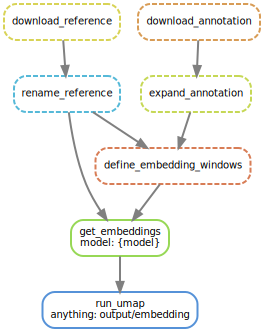

In [4]:
from IPython.core.display import SVG
SVG(filename='umap_flow.svg')

In [1]:
import bioframe as bf
import gpn.model
from gpn.data import load_table, Genome
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from umap import UMAP
import umap
# import umap.plot

In [3]:
gtf = load_table("output/annotation.gtf.gz")

gtf

chrom  source                feature  start       end score  \
0       NC_087394.1  RefSeq                 region      0  37460696     .   
1       NC_087394.1  Gnomon                   gene  66515    139762     .   
2       NC_087394.1  Gnomon                   mRNA  66515    139762     .   
3       NC_087394.1  Gnomon                   exon  66515     67099     .   
4       NC_087394.1  Gnomon                   exon  85756     85846     .   
...             ...     ...                    ...    ...       ...   ...   
387116  NC_003081.2  RefSeq                   exon  13798     13867     .   
387117  NC_003081.2  RefSeq                   gene  13868     14642     .   
387118  NC_003081.2  RefSeq                   rRNA  13868     14642     .   
387119  NC_003081.2  RefSeq                   exon  13868     14642     .   
387120  NC_003081.2  RefSeq  origin_of_replication  14642     15881     .   

       strand frame                                          attribute  
0           +     .  ID=NC_087394.1:1..37460696;Dbxref=taxon:7070;N...  
1           +     .  ID=gene-LOC656506;Dbxref=GeneID:656506;Name=LO...  
2           +     .  ID=rna-XM_008199260.3;Parent=gene-LOC656506;Db...  
3           +     .  ID=exon-XM_008199260.3-1;Parent=rna-XM_0081992...  
4           +     .  ID=exon-XM_008199260.3-2;Parent=rna-XM_0081992...  
...       ...   ...                                                ...  
387116      -     .  ID=exon-KEF75_t22-1;Parent=rna-KEF75_t22;Dbxre...  
387117      -     .  ID=gene-KEF75_r01;Dbxref=GeneID:64985796;Name=...  
387118      -     .  ID=rna-KEF75_r01;Parent=gene-KEF75_r01;Dbxref=...  
387119      -     .  ID=exon-KEF75_r01-1;Parent=rna-KEF75_r01;Dbxre...  
387120      +     .  ID=id-NC_003081.2:14643..15881;Note=A+T region...  

[387121 rows x 9 columns]

In [32]:
gtf[gtf["feature"]=="gene"]["attribute"].values

array(['ID=gene-LOC656506;Dbxref=GeneID:656506;Name=LOC656506;description=puratrophin-1;gbkey=Gene;gene=LOC656506;gene_biotype=protein_coding',
       'ID=gene-TRNAV-UAC;Dbxref=GeneID:135268018;Name=TRNAV-UAC;description=transfer RNA valine (anticodon UAC);gbkey=Gene;gene=TRNAV-UAC;gene_biotype=tRNA',
       'ID=gene-LOC135267949;Dbxref=GeneID:135267949;Name=LOC135267949;description=U6 spliceosomal RNA;gbkey=Gene;gene=LOC135267949;gene_biotype=snRNA',
       ...,
       'ID=gene-KEF75_r02;Dbxref=GeneID:64985794;Name=KEF75_r02;gbkey=Gene;gene_biotype=rRNA;locus_tag=KEF75_r02',
       'ID=gene-KEF75_t22;Dbxref=GeneID:64985795;Name=KEF75_t22;gbkey=Gene;gene_biotype=tRNA;locus_tag=KEF75_t22',
       'ID=gene-KEF75_r01;Dbxref=GeneID:64985796;Name=KEF75_r01;gbkey=Gene;gene_biotype=rRNA;locus_tag=KEF75_r01'],
      dtype=object)

In [41]:
sum(gtf.attribute.str.find("prime") >= 0)

30

In [45]:
gtf[gtf.attribute.str.find("prime") >= 0]["attribute"].values

array(['ID=gene-LOC103312496;Dbxref=GeneID:103312496;Name=LOC103312496;description=three prime repair exonuclease 2;gbkey=Gene;gene=LOC103312496;gene_biotype=protein_coding',
       'ID=rna-XM_008193245.3;Parent=gene-LOC103312496;Dbxref=GeneID:103312496,GenBank:XM_008193245.3;Name=XM_008193245.3;experiment=COORDINATES: polyA evidence [ECO:0006239];gbkey=mRNA;gene=LOC103312496;model_evidence=Supporting evidence includes similarity to: 1 Protein;product=three prime repair exonuclease 2;transcript_id=XM_008193245.3',
       'ID=exon-XM_008193245.3-1;Parent=rna-XM_008193245.3;Dbxref=GeneID:103312496,GenBank:XM_008193245.3;experiment=COORDINATES: polyA evidence [ECO:0006239];gbkey=mRNA;gene=LOC103312496;product=three prime repair exonuclease 2;transcript_id=XM_008193245.3',
       'ID=exon-XM_008193245.3-2;Parent=rna-XM_008193245.3;Dbxref=GeneID:103312496,GenBank:XM_008193245.3;experiment=COORDINATES: polyA evidence [ECO:0006239];gbkey=mRNA;gene=LOC103312496;product=three prime repair exonu

In [23]:
genic_features = [
    "gene", "mRNA", "transcript", "lnc_RNA", "primary_transcript", "pseudogene",
    "tRNA", "snRNA", "miRNA", "rRNA", "snoRNA", "ncRNA", "piRNA", "cDNA_match"
]

# 1. Extract the chromosome/region intervals. 
# Many GTF files include rows with feature "region" covering entire chromosomes.
chrom_regions = gtf[gtf.feature == "region"][["chrom", "start", "end"]]

# 2. Extract all intervals that represent genes or transcripts.
genic_intervals = gtf[gtf.feature.isin(genic_features)][["chrom", "start", "end"]]

# Merge overlapping genic intervals to form the union of all genic regions.
genic_intervals = bf.merge(genic_intervals)

# 3. Subtract the genic intervals from the full chromosome intervals
# to get intergenic regions.
intergenic = bf.subtract(chrom_regions, genic_intervals)

# Tag these intervals as "intergenic"
intergenic["feature"] = "intergenic"

intergenic

chrom   start     end     feature
0      NC_087394.1       0   66515  intergenic
1      NC_087394.1  139762  139830  intergenic
2      NC_087394.1  139903  140295  intergenic
3      NC_087394.1  140402  146999  intergenic
4      NC_087394.1  147072  147150  intergenic
...            ...     ...     ...         ...
11187  NC_003081.2    9781    9785  intergenic
11188  NC_003081.2   11484   11502  intergenic
11189  NC_003081.2   13797   13798  intergenic
11190  NC_003081.2   13867   13868  intergenic
11191  NC_003081.2   14642   15881  intergenic

[11192 rows x 4 columns]

In [55]:
gtf_exon = gtf[gtf.feature == "exon"] #  & gtf.source == "Gnomon"
gtf_exon["transcript_id"] = (
            gtf_exon.attribute.str.extract(r'(?<=D=exon-)(.*?)(?=-)')
        )
gtf_exon

/tmp/ipykernel_393233/4167807629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_exon["transcript_id"] = (


chrom  source feature   start     end score strand frame  \
3       NC_087394.1  Gnomon    exon   66515   67099     .      +     .   
4       NC_087394.1  Gnomon    exon   85756   85846     .      +     .   
5       NC_087394.1  Gnomon    exon  103121  103239     .      +     .   
6       NC_087394.1  Gnomon    exon  108757  108944     .      +     .   
7       NC_087394.1  Gnomon    exon  112655  112897     .      +     .   
...             ...     ...     ...     ...     ...   ...    ...   ...   
387106  NC_003081.2  RefSeq    exon   11502   12456     .      -     .   
387110  NC_003081.2  RefSeq    exon   12453   12517     .      -     .   
387113  NC_003081.2  RefSeq    exon   12517   13797     .      -     .   
387116  NC_003081.2  RefSeq    exon   13798   13867     .      -     .   
387119  NC_003081.2  RefSeq    exon   13868   14642     .      -     .   

                                                attribute   transcript_id  
3       ID=exon-XM_008199260.3-1;Parent=rna-XM_0081992...  XM_008199260.3  
4       ID=exon-XM_008199260.3-2;Parent=rna-XM_0081992...  XM_008199260.3  
5       ID=exon-XM_008199260.3-3;Parent=rna-XM_0081992...  XM_008199260.3  
6       ID=exon-XM_008199260.3-4;Parent=rna-XM_0081992...  XM_008199260.3  
7       ID=exon-XM_008199260.3-5;Parent=rna-XM_0081992...  XM_008199260.3  
...                                                   ...             ...  
387106  ID=exon-KEF75_p01-1;Parent=rna-KEF75_p01;Dbxre...       KEF75_p01  
387110  ID=exon-KEF75_t21-1;Parent=rna-KEF75_t21;Dbxre...       KEF75_t21  
387113  ID=exon-KEF75_r02-1;Parent=rna-KEF75_r02;Dbxre...       KEF75_r02  
387116  ID=exon-KEF75_t22-1;Parent=rna-KEF75_t22;Dbxre...       KEF75_t22  
387119  ID=exon-KEF75_r01-1;Parent=rna-KEF75_r01;Dbxre...       KEF75_r01  

[186589 rows x 10 columns]

In [16]:
import more_itertools

def get_transcript_introns(df_transcript):
            df_transcript = df_transcript.sort_values("start")
            exon_pairs = more_itertools.pairwise(
                df_transcript.loc[:, ["start", "end"]].values
            )
            introns = [[e1[1], e2[0]] for e1, e2 in exon_pairs]
            introns = pd.DataFrame(introns, columns=["start", "end"])
            introns["chrom"] = df_transcript.chrom.iloc[0]
            return introns


# gtf_introns = (
#     gtf_exon.groupby("transcript_id")
#     .apply(get_transcript_introns)
#     .reset_index()
#     .drop_duplicates(subset=["chrom", "start", "end"])
# )

# gtf_introns["feature"] = "intron"

# gtf_introns

In [53]:
gtf_exon.iloc[[-1]].attribute.str.extract(r'(?<=D=exon-)(.*?)(?=-)')

0
387119  KEF75_r01

In [41]:
gtf_exon.head(1).attribute.str.split(";").str[-1].str.split("=").str[-1]

3    XM_008199260.3
Name: attribute, dtype: object

In [4]:
extended_annotation = pd.read_parquet("output/annotation.expanded.parquet")

extended_annotation

chrom  source feature    start       end score strand frame  \
0       NC_087394.1  RefSeq  region        0  37460696     .      +     .   
1       NC_087394.1  Gnomon    gene    66515    139762     .      +     .   
2       NC_087394.1  Gnomon    mRNA    66515    139762     .      +     .   
3       NC_087394.1  Gnomon    exon    66515     67099     .      +     .   
4       NC_087394.1  Gnomon    exon    85756     85846     .      +     .   
...             ...     ...     ...      ...       ...   ...    ...   ...   
471858  NC_087397.1    None  intron  7359573   7359621  None   None  None   
471859  NC_087397.1    None  intron  7359732   7362496  None   None  None   
471860  NC_087397.1    None  intron  3413814   3413863  None   None  None   
471861  NC_087397.1    None  intron  3414038   3414096  None   None  None   
471862  NC_087397.1    None  intron  2133824   2135896  None   None  None   

                                                attribute transcript_id  \
0       ID=NC_087394.1:1..37460696;Dbxref=taxon:7070;N...          None   
1       ID=gene-LOC656506;Dbxref=GeneID:656506;Name=LO...          None   
2       ID=rna-XM_008199260.3;Parent=gene-LOC656506;Db...          None   
3       ID=exon-XM_008199260.3-1;Parent=rna-XM_0081992...          None   
4       ID=exon-XM_008199260.3-2;Parent=rna-XM_0081992...          None   
...                                                   ...           ...   
471858                                               None   XR_511827.3   
471859                                               None   XR_511827.3   
471860                                               None   XR_511834.3   
471861                                               None   XR_511834.3   
471862                                               None   XR_511841.2   

        level_1  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
471858      2.0  
471859      3.0  
471860      0.0  
471861      1.0  
471862      1.0  

[471863 rows x 11 columns]

In [6]:
bf.is_bedframe(extended_annotation, raise_errors=True)

ValueError: Invalid bedframe: starts exceed ends for 2 intervals

In [9]:
extended_annotation[extended_annotation["end"] - extended_annotation["start"] < 0]

chrom source feature    start      end score strand frame  \
398633  NC_087397.1   None  intron  7255370  7255349  None   None  None   
398635  NC_087397.1   None  intron  7255405  7255382  None   None  None   

       attribute transcript_id  level_1  
398633      None        Miriab      0.0  
398635      None        Miriab      2.0

In [23]:
gtf_exon = extended_annotation[extended_annotation.feature == "exon"] #  & gtf.source == "Gnomon"
gtf_exon["transcript_id"] = (
            gtf_exon.attribute.str.extract(r'(?<=ID=exon-)(.*?)(?=-\d+;)')
        )
gtf_exon

/tmp/ipykernel_367063/1012402029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_exon["transcript_id"] = (


chrom  source feature   start     end score strand frame  \
3       NC_087394.1  Gnomon    exon   66515   67099     .      +     .   
4       NC_087394.1  Gnomon    exon   85756   85846     .      +     .   
5       NC_087394.1  Gnomon    exon  103121  103239     .      +     .   
6       NC_087394.1  Gnomon    exon  108757  108944     .      +     .   
7       NC_087394.1  Gnomon    exon  112655  112897     .      +     .   
...             ...     ...     ...     ...     ...   ...    ...   ...   
387106  NC_003081.2  RefSeq    exon   11502   12456     .      -     .   
387110  NC_003081.2  RefSeq    exon   12453   12517     .      -     .   
387113  NC_003081.2  RefSeq    exon   12517   13797     .      -     .   
387116  NC_003081.2  RefSeq    exon   13798   13867     .      -     .   
387119  NC_003081.2  RefSeq    exon   13868   14642     .      -     .   

                                                attribute   transcript_id  \
3       ID=exon-XM_008199260.3-1;Parent=rna-XM_0081992...  XM_008199260.3   
4       ID=exon-XM_008199260.3-2;Parent=rna-XM_0081992...  XM_008199260.3   
5       ID=exon-XM_008199260.3-3;Parent=rna-XM_0081992...  XM_008199260.3   
6       ID=exon-XM_008199260.3-4;Parent=rna-XM_0081992...  XM_008199260.3   
7       ID=exon-XM_008199260.3-5;Parent=rna-XM_0081992...  XM_008199260.3   
...                                                   ...             ...   
387106  ID=exon-KEF75_p01-1;Parent=rna-KEF75_p01;Dbxre...       KEF75_p01   
387110  ID=exon-KEF75_t21-1;Parent=rna-KEF75_t21;Dbxre...       KEF75_t21   
387113  ID=exon-KEF75_r02-1;Parent=rna-KEF75_r02;Dbxre...       KEF75_r02   
387116  ID=exon-KEF75_t22-1;Parent=rna-KEF75_t22;Dbxre...       KEF75_t22   
387119  ID=exon-KEF75_r01-1;Parent=rna-KEF75_r01;Dbxre...       KEF75_r01   

        level_1  
3           NaN  
4           NaN  
5           NaN  
6           NaN  
7           NaN  
...         ...  
387106      NaN  
387110      NaN  
387113      NaN  
387116      NaN  
387119      NaN  

[186589 rows x 11 columns]

In [26]:
gtf_miriab = gtf_exon[gtf_exon["transcript_id"] == "Miriab-8-2"].sort_values("start")
gtf_miriab

chrom      source feature    start      end score strand frame  \
173280  NC_087397.1  BestRefSeq    exon  7255379  7255405     .      -     .   

                                                attribute transcript_id  \
173280  ID=exon-Miriab-8-2-1;Parent=rna-Miriab-8-2;Dbx...    Miriab-8-2   

        level_1  
173280      NaN

In [19]:
miriab_introns = get_transcript_introns(gtf_miriab)
miriab_introns

start      end        chrom
0  7255370  7255349  NC_087397.1
1  7255368  7255379  NC_087397.1
2  7255405  7255382  NC_087397.1

In [21]:
sum(miriab_introns["end"] - miriab_introns["start"] < 0)

2

In [4]:
pd.unique(extended_annotation["feature"])

array(['region', 'gene', 'mRNA', 'exon', 'CDS', 'tRNA', 'snRNA',
       'transcript', 'lnc_RNA', 'primary_transcript', 'miRNA',
       'pseudogene', 'rRNA', 'snoRNA', 'cDNA_match', 'ncRNA', 'piRNA',
       'origin_of_replication'], dtype=object)

In [3]:
windows = pd.read_parquet("output/embedding/windows.parquet")

In [33]:
from gpn.data import load_table, Genome, filter_length, make_windows

WINDOW_SIZE = 512

gtf = pd.read_parquet("output/annotation.expanded.parquet")
genome = Genome("output/genome.fa")
genome.filter_chroms(["1", "2", "3", "4", "5"])
defined_intervals = genome.get_defined_intervals()
defined_intervals = filter_length(defined_intervals, WINDOW_SIZE)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.46it/s]


In [38]:
gtf[gtf["feature"]=="intron"]

r = bf.coverage(windows, gtf[gtf["feature"]=="intron"])
r[r["coverage"] > 0]

Empty DataFrame
Columns: [chrom, full_start, full_end, strand, start, end, intergenic, CDS, intron, coverage]
Index: []

In [14]:
EMBEDDING_WINDOW_SIZE = 100

windows = make_windows(defined_intervals, WINDOW_SIZE, EMBEDDING_WINDOW_SIZE)
windows.rename(columns={"start": "full_start", "end": "full_end"}, inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 126.64it/s]


In [16]:
windows["start"] = (
    windows.full_start + windows.full_end
) // 2 - EMBEDDING_WINDOW_SIZE // 2
windows["end"] = windows.start + EMBEDDING_WINDOW_SIZE

In [19]:
features_of_interest = [
    "intergenic",
    "CDS",
    "intron",
    # "three_prime_UTR",
    # "five_prime_UTR",
    # "ncRNA_gene",
    # "Repeat",
]
for f in features_of_interest:
    print(f)
    windows = bf.coverage(windows, gtf[gtf.feature == f])
    windows.rename(columns=dict(coverage=f), inplace=True)

intergenic
CDS
intron


In [40]:
gtf

chrom  source feature    start       end score strand frame  \
0       NC_087394.1  RefSeq  region        0  37460696     .      +     .   
1       NC_087394.1  Gnomon    gene    66515    139762     .      +     .   
2       NC_087394.1  Gnomon    mRNA    66515    139762     .      +     .   
3       NC_087394.1  Gnomon    exon    66515     67099     .      +     .   
4       NC_087394.1  Gnomon    exon    85756     85846     .      +     .   
...             ...     ...     ...      ...       ...   ...    ...   ...   
471858  NC_087397.1    None  intron  7359573   7359621  None   None  None   
471859  NC_087397.1    None  intron  7359732   7362496  None   None  None   
471860  NC_087397.1    None  intron  3413814   3413863  None   None  None   
471861  NC_087397.1    None  intron  3414038   3414096  None   None  None   
471862  NC_087397.1    None  intron  2133824   2135896  None   None  None   

                                                attribute transcript_id  \
0       ID=NC_087394.1:1..37460696;Dbxref=taxon:7070;N...          None   
1       ID=gene-LOC656506;Dbxref=GeneID:656506;Name=LO...          None   
2       ID=rna-XM_008199260.3;Parent=gene-LOC656506;Db...          None   
3       ID=exon-XM_008199260.3-1;Parent=rna-XM_0081992...          None   
4       ID=exon-XM_008199260.3-2;Parent=rna-XM_0081992...          None   
...                                                   ...           ...   
471858                                               None   XR_511827.3   
471859                                               None   XR_511827.3   
471860                                               None   XR_511834.3   
471861                                               None   XR_511834.3   
471862                                               None   XR_511841.2   

        level_1  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
471858      2.0  
471859      3.0  
471860      0.0  
471861      1.0  
471862      1.0  

[471863 rows x 11 columns]

In [39]:
windows

chrom  full_start  full_end strand     start       end  intergenic  \
0           1           0       512      +       206       306           0   
1           1         100       612      +       306       406           0   
2           1         200       712      +       406       506           0   
3           1         300       812      +       506       606           0   
4           1         400       912      +       606       706           0   
...       ...         ...       ...    ...       ...       ...         ...   
1331088     5    20635500  20636012      +  20635706  20635806           0   
1331089     5    20635600  20636112      +  20635806  20635906           0   
1331090     5    20635700  20636212      +  20635906  20636006           0   
1331091     5    20635800  20636312      +  20636006  20636106           0   
1331092     5    20635900  20636412      +  20636106  20636206           0   

         CDS  intron  
0          0       0  
1          0       0  
2          0       0  
3          0       0  
4          0       0  
...      ...     ...  
1331088    0       0  
1331089    0       0  
1331090    0       0  
1331091    0       0  
1331092    0       0  

[1331093 rows x 9 columns]

In [42]:
overlapping_intervals = bf.overlap(windows, gtf)
display(overlapping_intervals)

chrom  full_start  full_end strand     start       end  intergenic  \
0           1           0       512      +       206       306           0   
1           1         100       612      +       306       406           0   
2           1         200       712      +       406       506           0   
3           1         300       812      +       506       606           0   
4           1         400       912      +       606       706           0   
...       ...         ...       ...    ...       ...       ...         ...   
1331088     5    20635500  20636012      +  20635706  20635806           0   
1331089     5    20635600  20636112      +  20635806  20635906           0   
1331090     5    20635700  20636212      +  20635906  20636006           0   
1331091     5    20635800  20636312      +  20636006  20636106           0   
1331092     5    20635900  20636412      +  20636106  20636206           0   

         CDS  intron chrom_ source_ feature_  start_  end_ score_ strand_  \
0          0       0   None    None     None    <NA>  <NA>   None    None   
1          0       0   None    None     None    <NA>  <NA>   None    None   
2          0       0   None    None     None    <NA>  <NA>   None    None   
3          0       0   None    None     None    <NA>  <NA>   None    None   
4          0       0   None    None     None    <NA>  <NA>   None    None   
...      ...     ...    ...     ...      ...     ...   ...    ...     ...   
1331088    0       0   None    None     None    <NA>  <NA>   None    None   
1331089    0       0   None    None     None    <NA>  <NA>   None    None   
1331090    0       0   None    None     None    <NA>  <NA>   None    None   
1331091    0       0   None    None     None    <NA>  <NA>   None    None   
1331092    0       0   None    None     None    <NA>  <NA>   None    None   

        frame_ attribute_ transcript_id_  level_1_  
0         None       None           None       NaN  
1         None       None           None       NaN  
2         None       None           None       NaN  
3         None       None           None       NaN  
4         None       None           None       NaN  
...        ...        ...            ...       ...  
1331088   None       None           None       NaN  
1331089   None       None           None       NaN  
1331090   None       None           None       NaN  
1331091   None       None           None       NaN  
1331092   None       None           None       NaN  

[1331093 rows x 20 columns]

/opt/conda/lib/python3.12/site-packages/bioframe/vis.py:122: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)


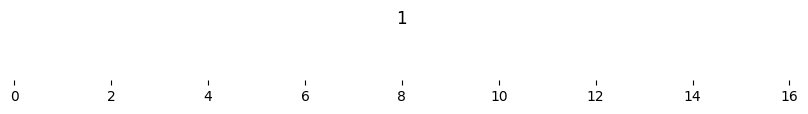

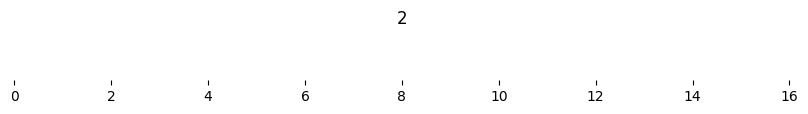

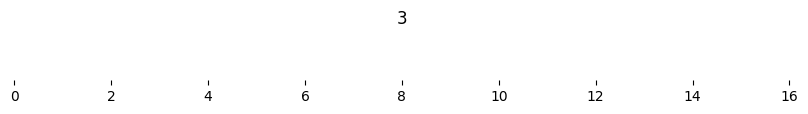

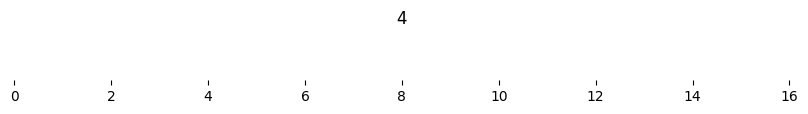

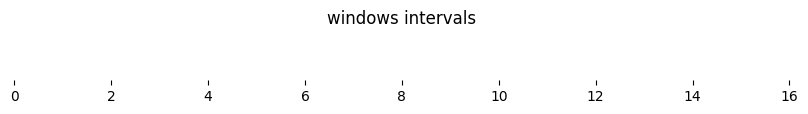

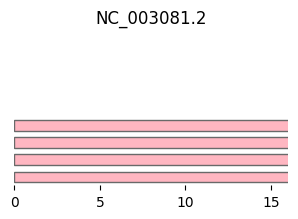

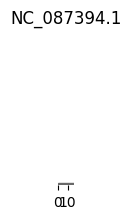

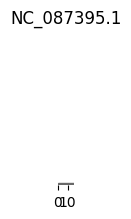

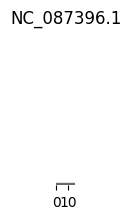

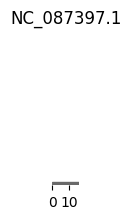

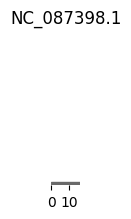

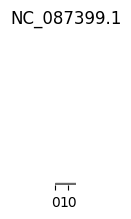

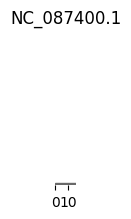

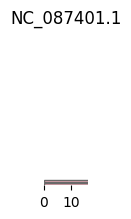

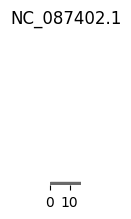

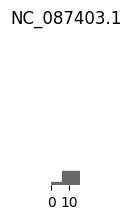

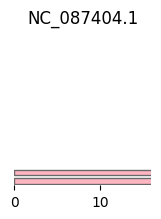

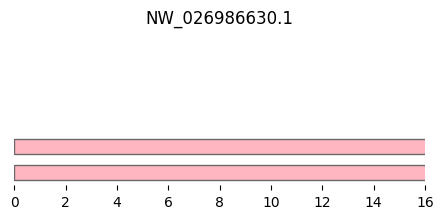

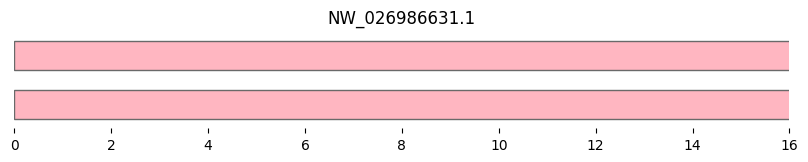

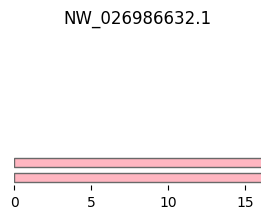

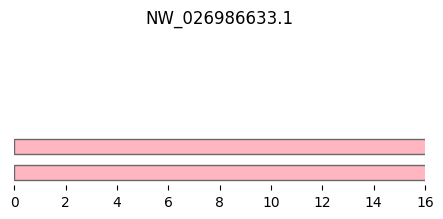

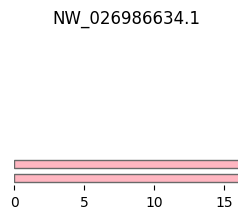

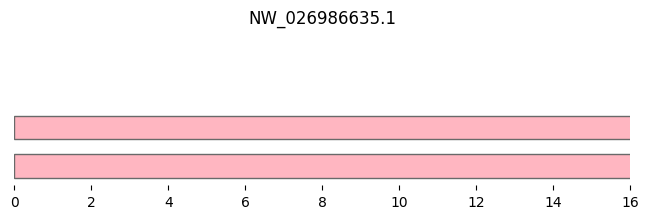

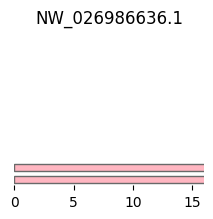

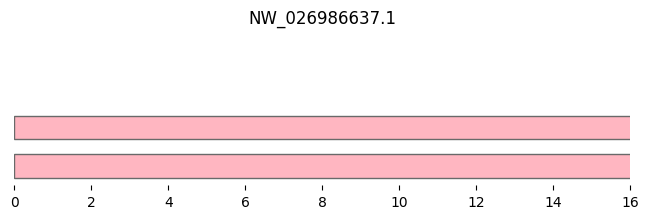

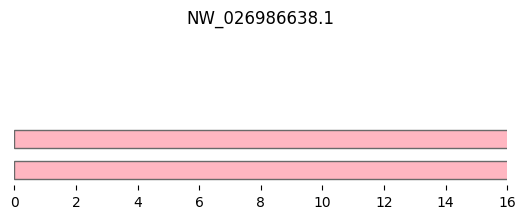

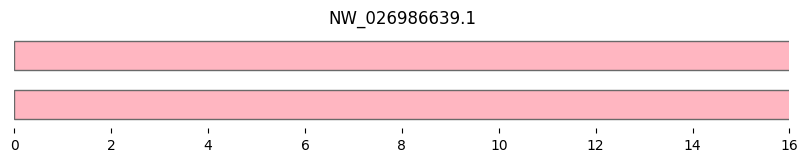

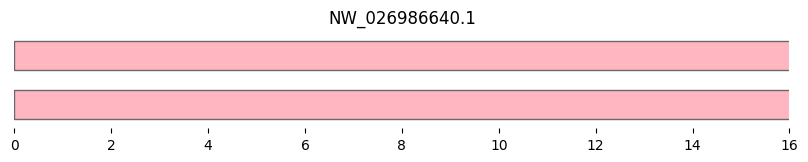

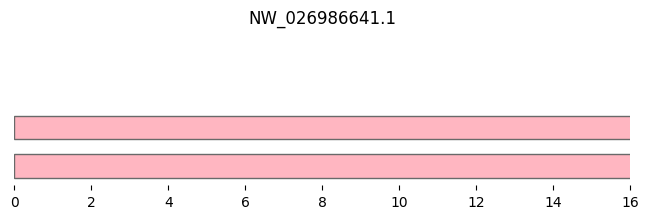

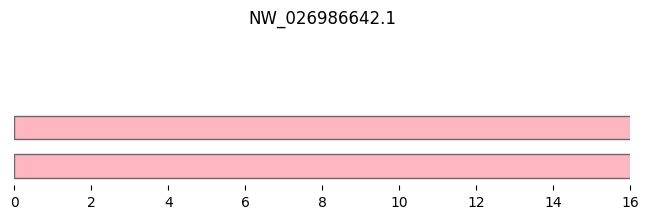

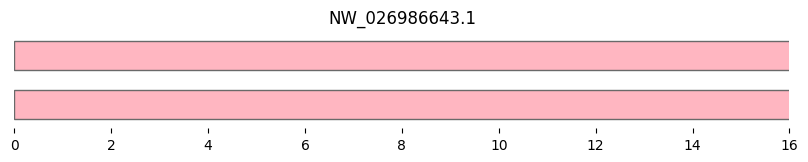

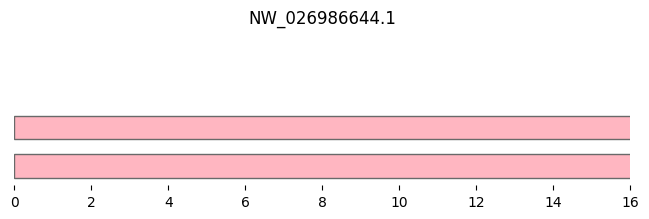

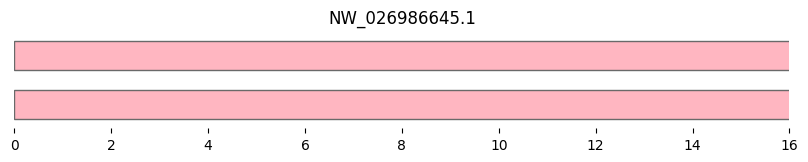

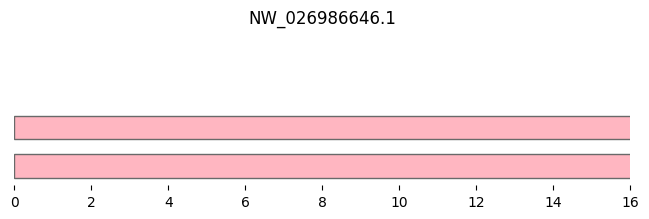

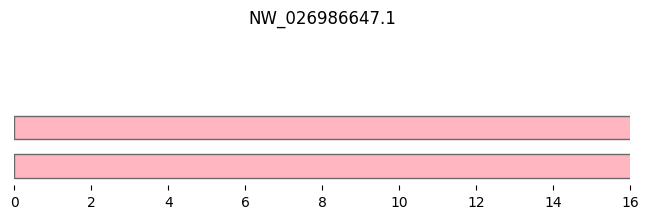

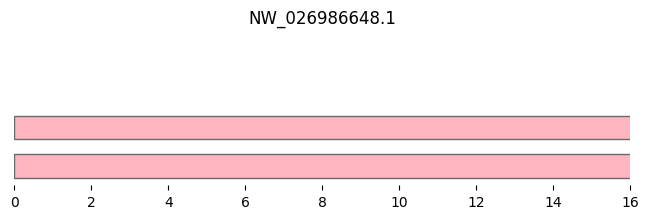

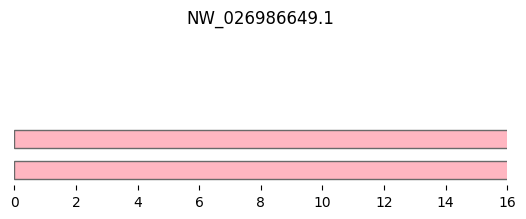

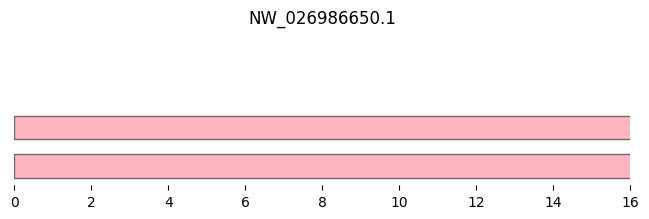

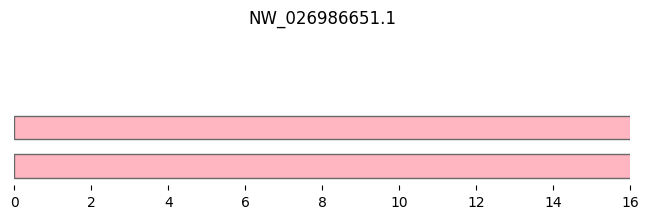

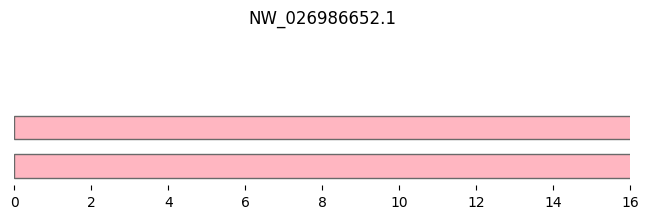

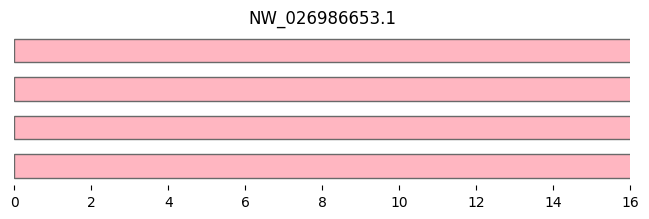

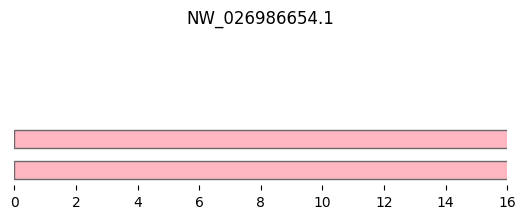

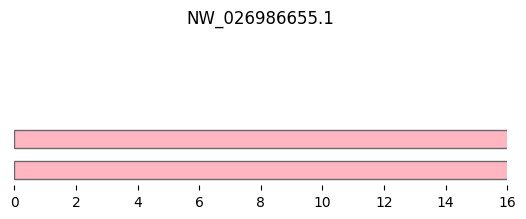

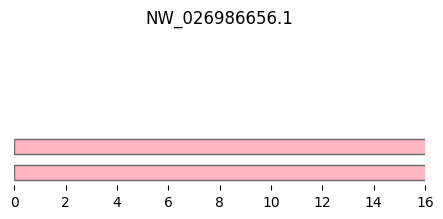

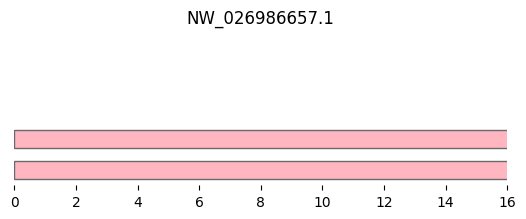

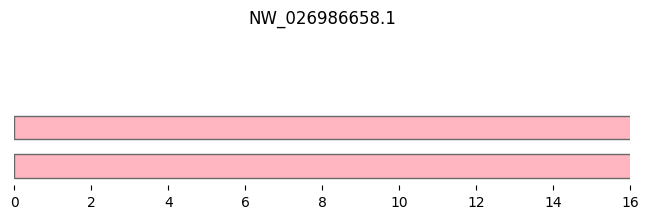

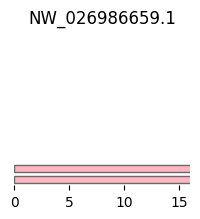

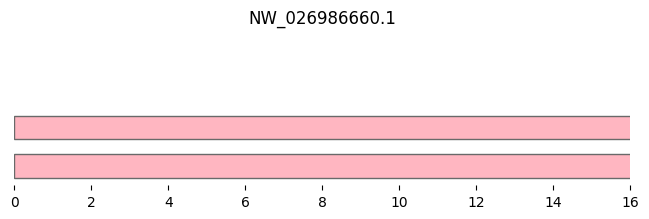

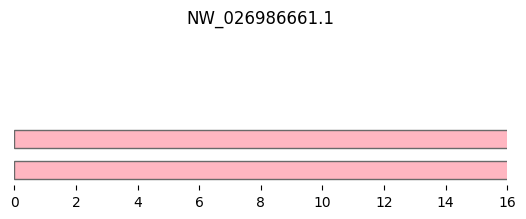

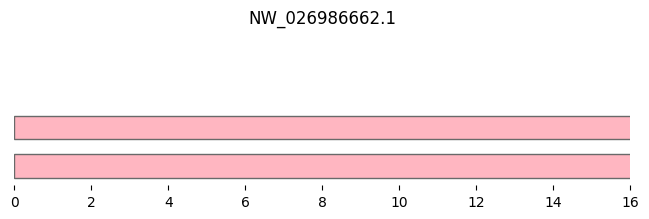

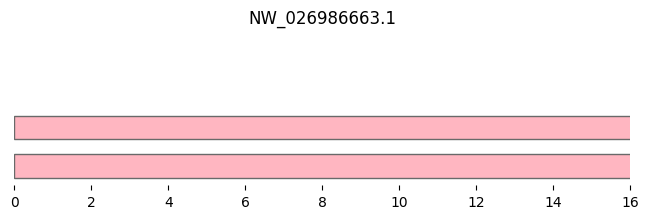

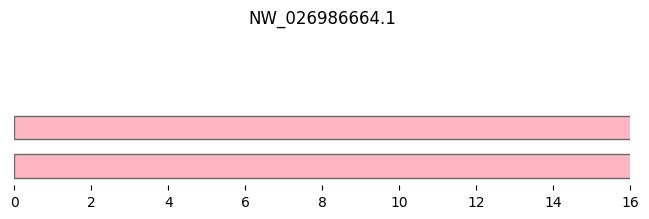

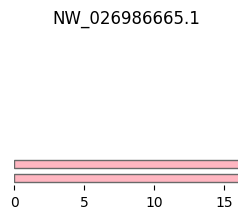

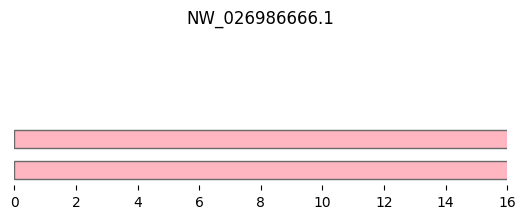

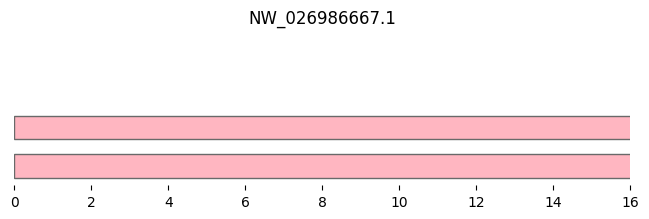

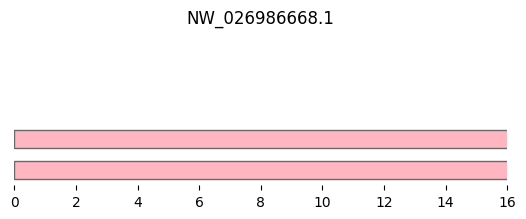

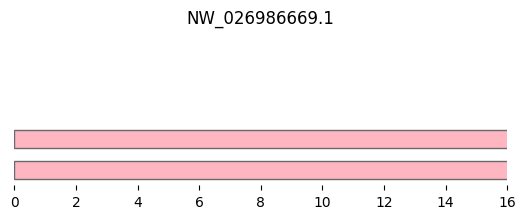

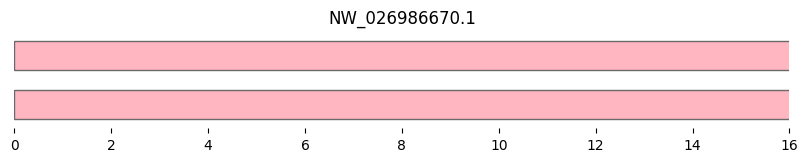

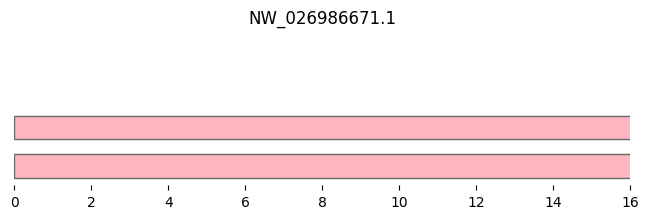

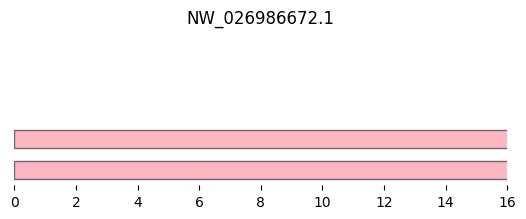

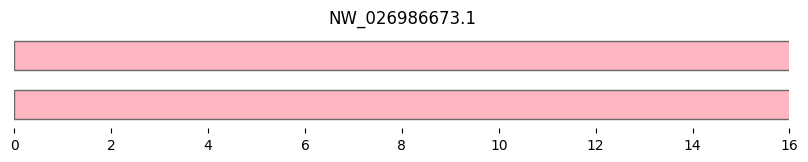

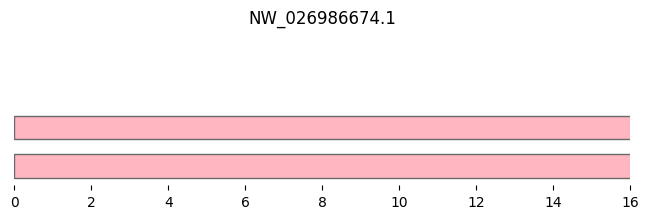

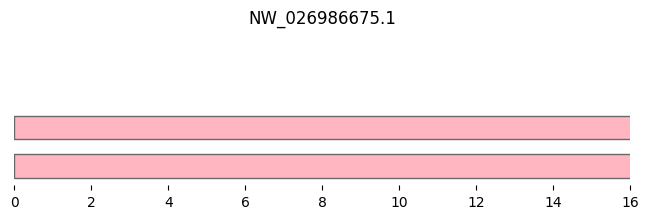

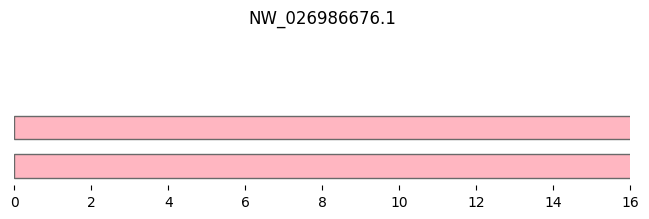

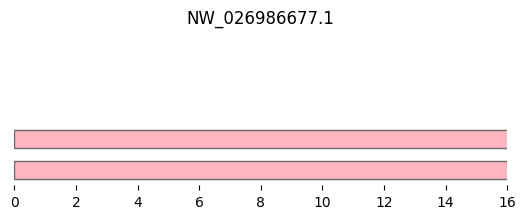

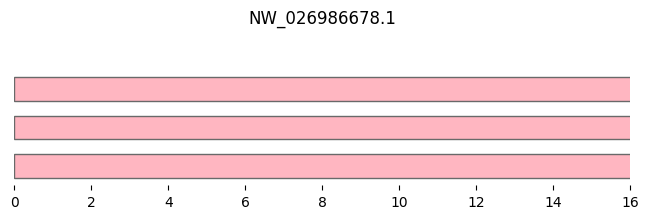

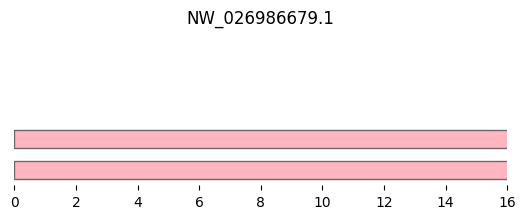

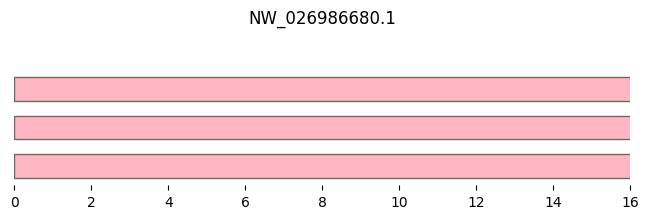

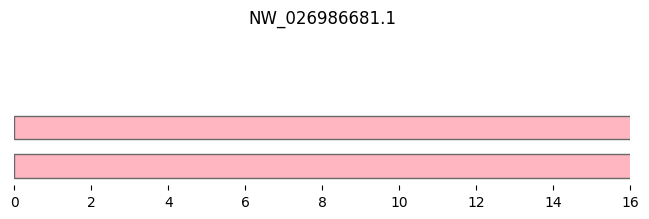

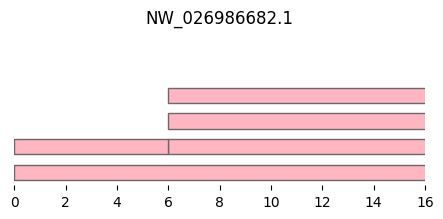

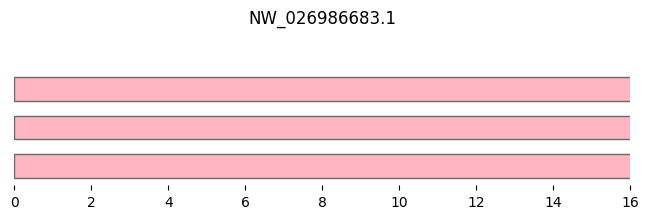

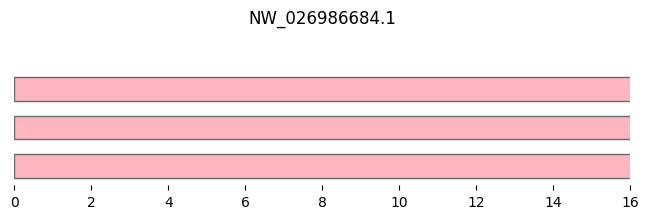

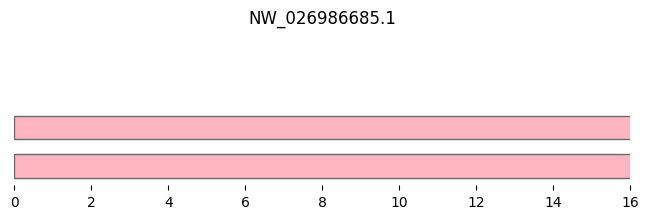

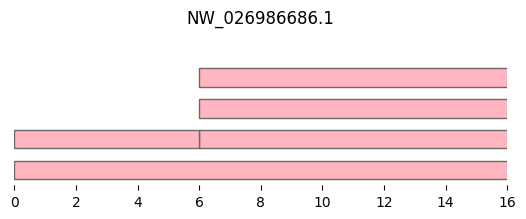

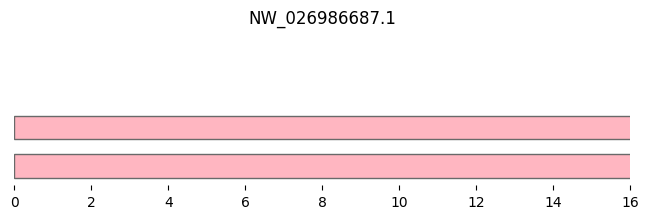

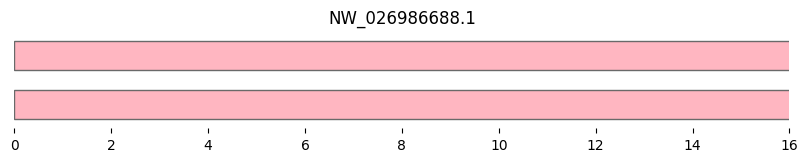

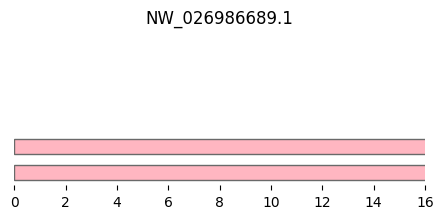

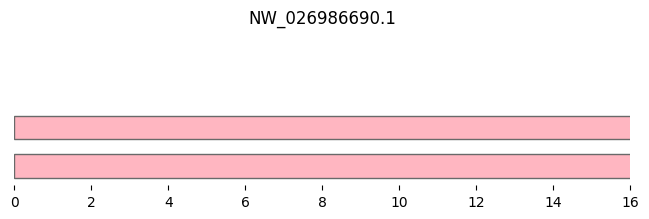

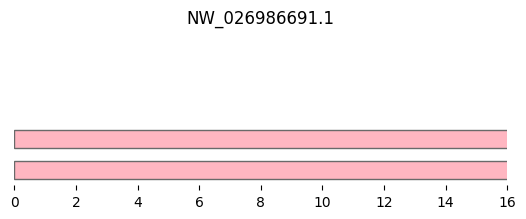

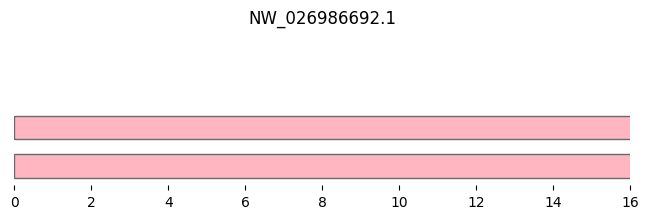

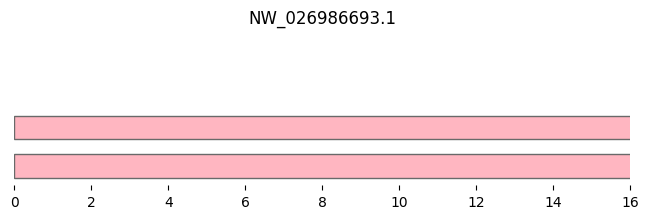

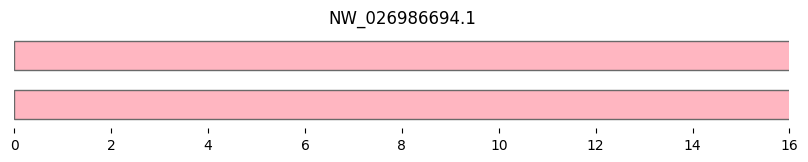

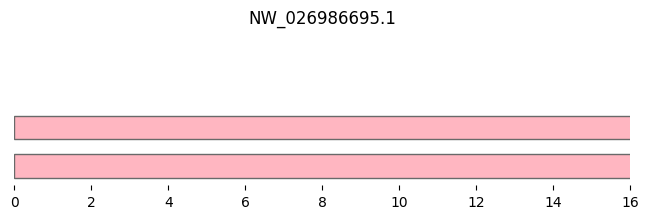

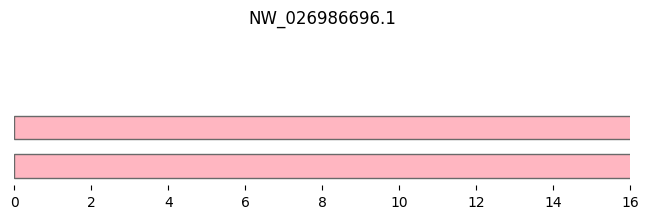

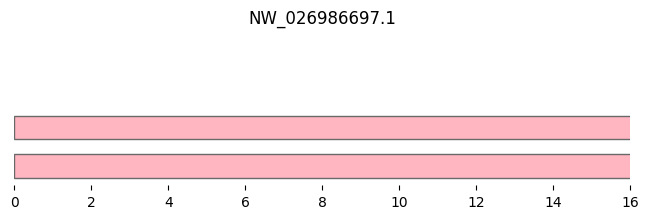

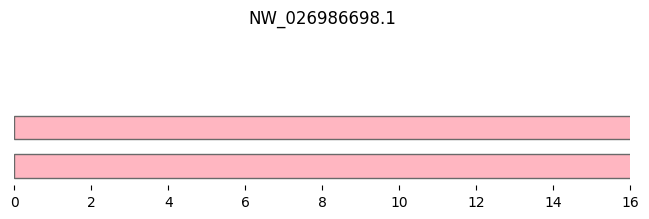

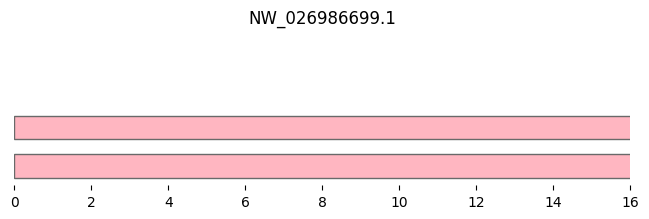

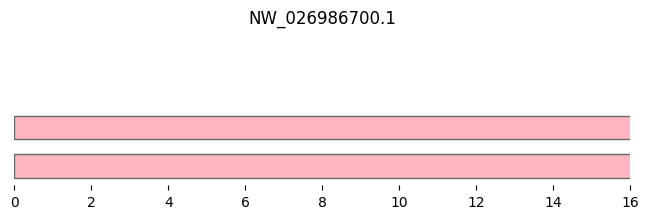

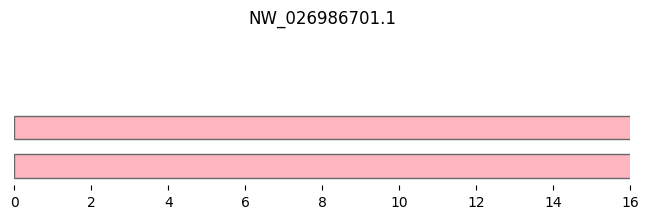

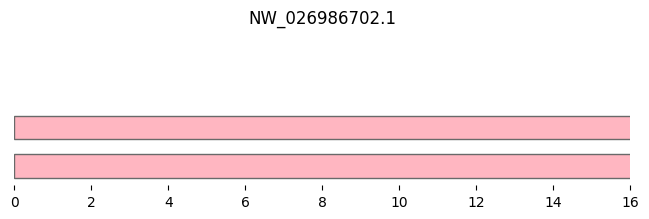

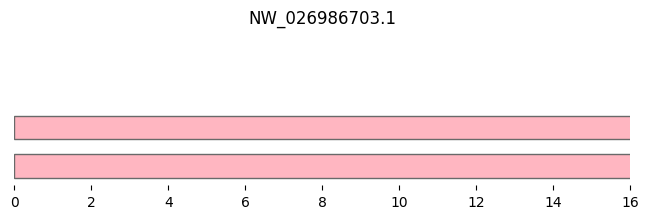

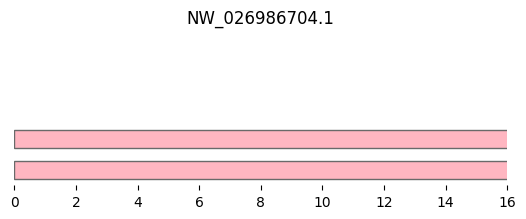

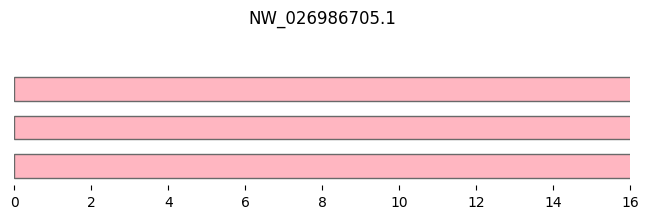

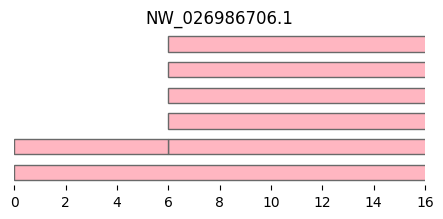

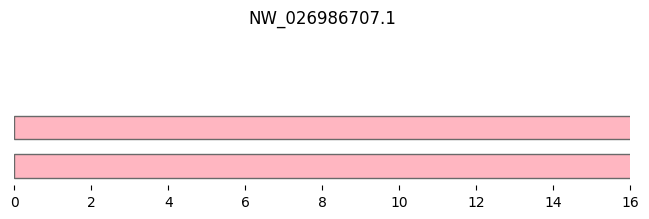

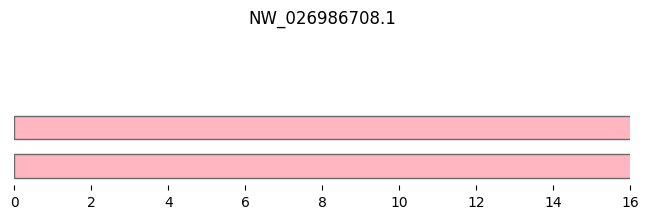

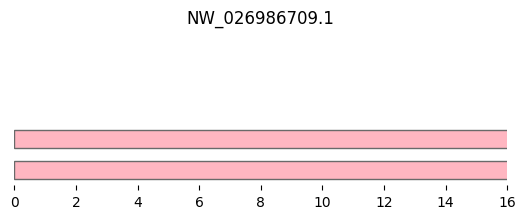

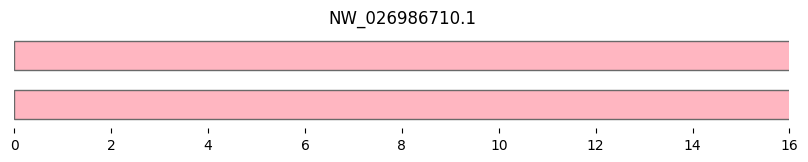

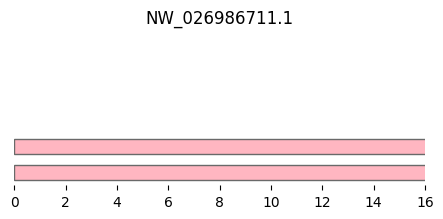

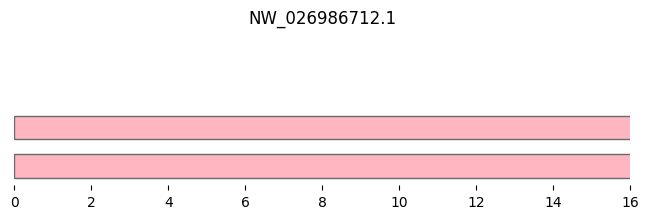

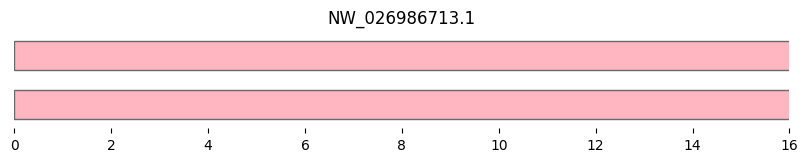

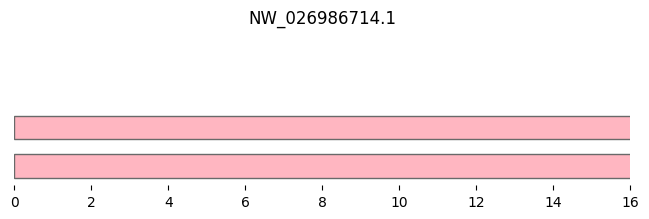

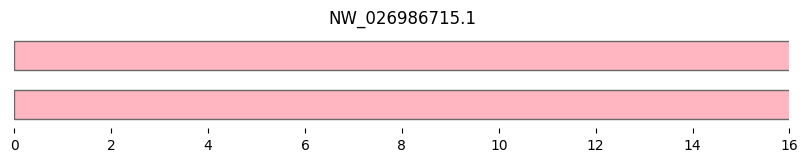

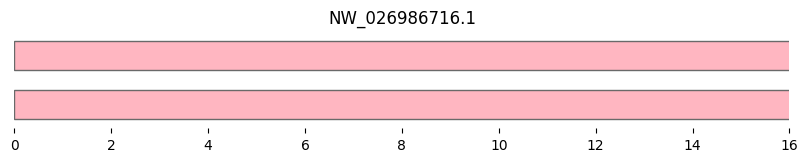

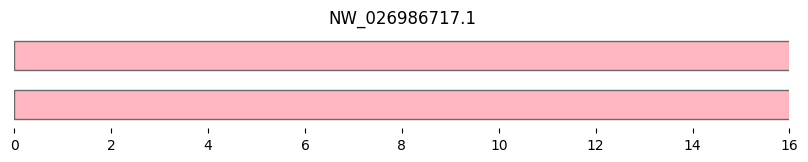

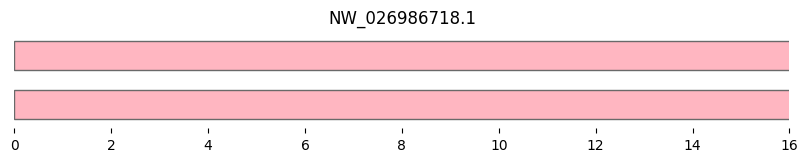

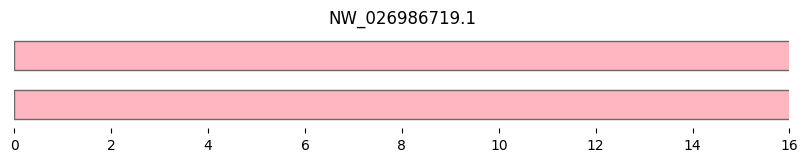

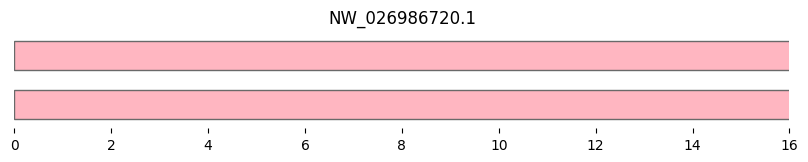

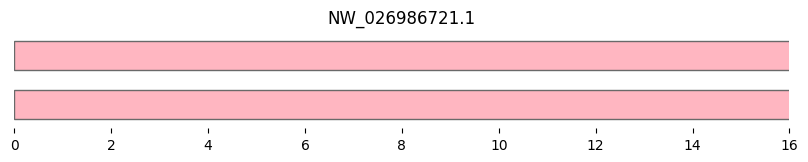

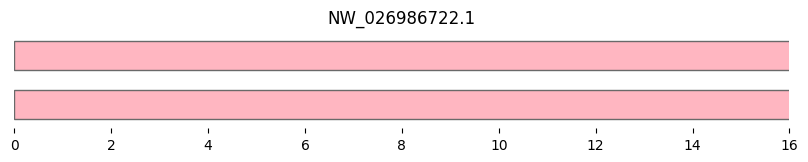

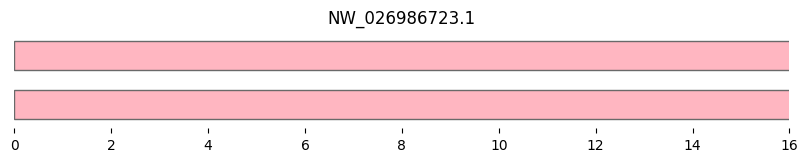

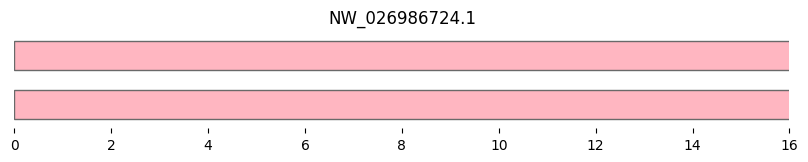

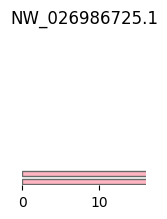

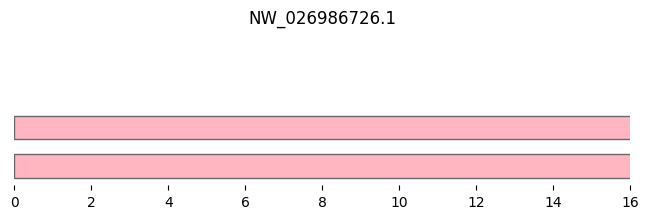

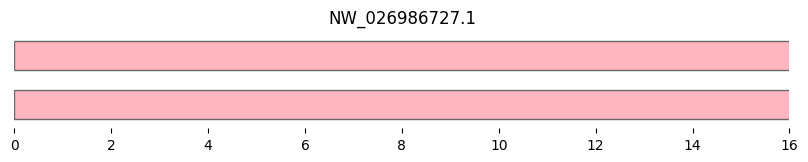

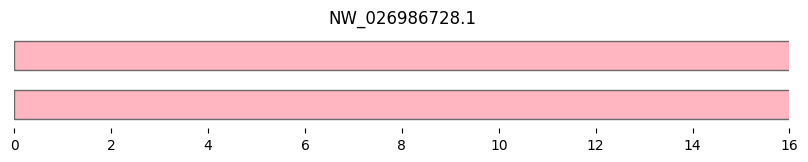

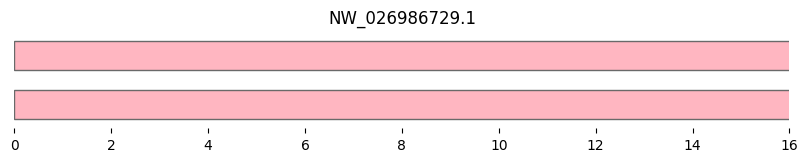

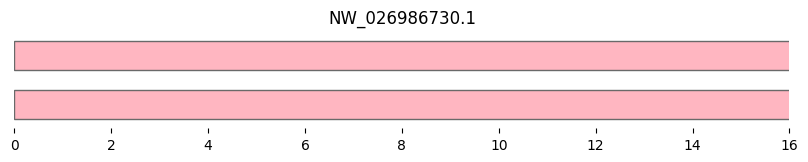

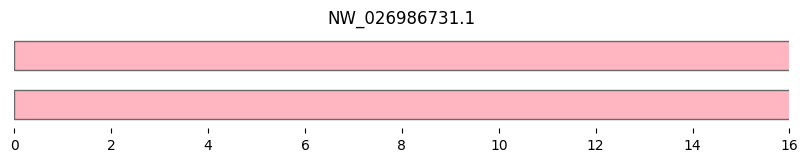

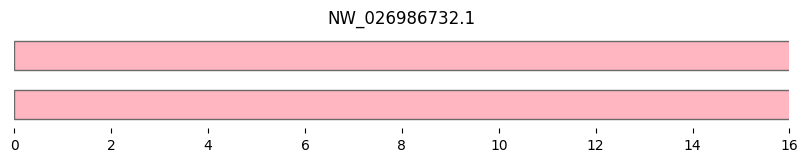

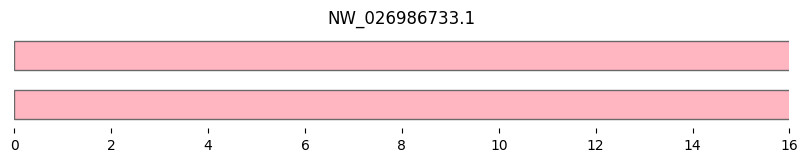

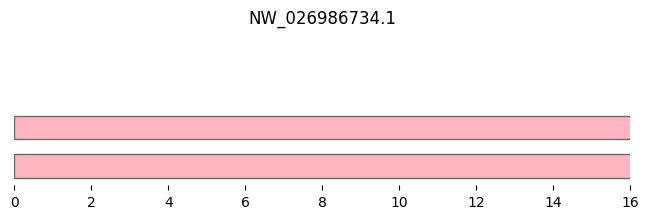

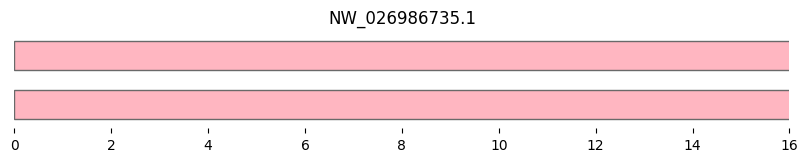

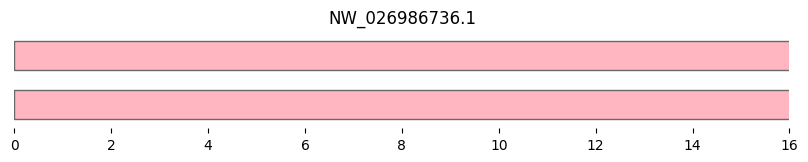

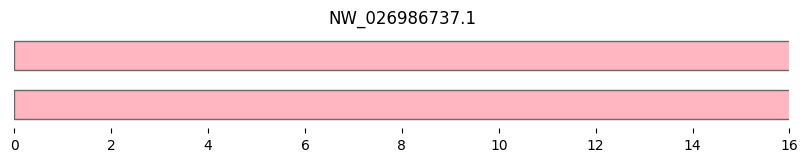

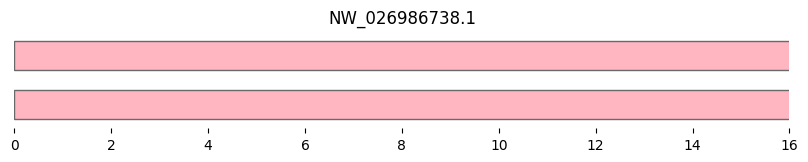

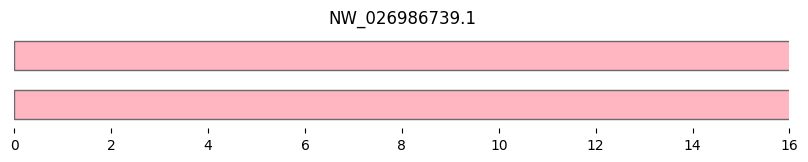

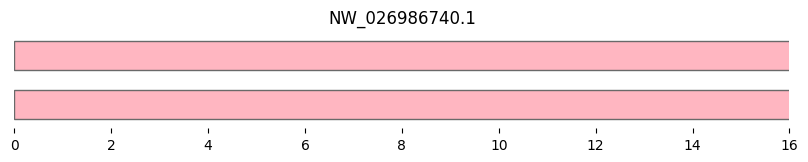

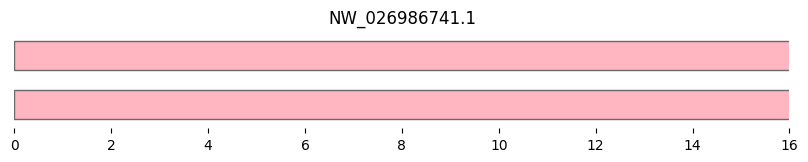

In [ ]:
bf.vis.plot_intervals(windows, show_coords=True, xlim=(0,16))
plt.title('windows intervals');

bf.vis.plot_intervals(gtf, show_coords=True, xlim=(0,16), colors='lightpink')
plt.title('gtf intervals');

In [3]:
MODEL = "gonzalobenegas/gpn-brassicales"
#MODEL = "kmers_5"

d = Path("output/embedding")
#d = Path("output/embedding/subset_no_repeats")

windows = pd.read_parquet(d / "windows.parquet")
windows.loc[:, ["UMAP1", "UMAP2"]] = pd.read_parquet(d / "umap" / f"{MODEL}.parquet").values
windows

chrom     start       end strand  center_start  center_end      Region  \
0          1         0       512      +           206         306  intergenic   
1          1       100       612      +           306         406  intergenic   
2          1       200       712      +           406         506  intergenic   
3          1       300       812      +           506         606  intergenic   
4          1       400       912      +           606         706  intergenic   
...      ...       ...       ...    ...           ...         ...         ...   
818088     5  26974534  26975046      +      26974740    26974840  intergenic   
818089     5  26974634  26975146      +      26974840    26974940  intergenic   
818090     5  26974734  26975246      +      26974940    26975040  intergenic   
818091     5  26974834  26975346      +      26975040    26975140  intergenic   
818092     5  26974934  26975446      +      26975140    26975240  intergenic   

           UMAP1     UMAP2  
0      -3.334120  6.901677  
1      -2.838706  6.807289  
2      -3.244478  6.347484  
3      -2.685449  6.857773  
4      -3.230633  6.375634  
...          ...       ...  
818088 -4.000669  7.249334  
818089 -6.549615  3.723410  
818090 -6.551815  4.804007  
818091 -5.501323  5.592935  
818092 -6.129354  3.453605  

[818093 rows x 9 columns]

In [4]:
windows.Region = windows.Region.replace({
    "intergenic": "Intergenic",
    "intron": "Intron",
    "ncRNA_gene": "ncRNA",
    "five_prime_UTR": "5' UTR",
    "three_prime_UTR": "3' UTR",
})

In [5]:
mapper = UMAP()
mapper.embedding_ = windows[["UMAP1", "UMAP2"]].values

In [6]:
def get_color_key(classes, palette):
    color_palette = sns.color_palette(palette, n_colors=len(classes)).as_hex()
    return {c: color_palette[i] for i, c in enumerate(classes)}

def umap_plot_labels(labels, title, label_order, cmap="tab10", save_to=None, **kwargs):
    g = umap.plot.points(
        mapper,
        labels=labels,
        subset_points=labels.isin(label_order),
        color_key=get_color_key(label_order, cmap),
        **kwargs,
    );
    sns.move_legend(g, "lower right")
    #sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1));
    g.legend_.set_title(title);
    sns.despine();
    for txt in g.texts:
        txt.set_visible(False)
    plt.xlabel("UMAP1")
    plt.ylabel("UMAP2")
    if save_to is not None:
        plt.savefig(save_to, bbox_inches="tight")

In [7]:
# default is 100
plt.rcParams["figure.dpi"] = 100 #200  # need to play with both this and height,width
plt.rcParams['font.size'] = 20

In [8]:
# avoid having both green and red
color_palette = np.array(sns.color_palette("tab10"))[[0,1,9,3,4,5,6]]

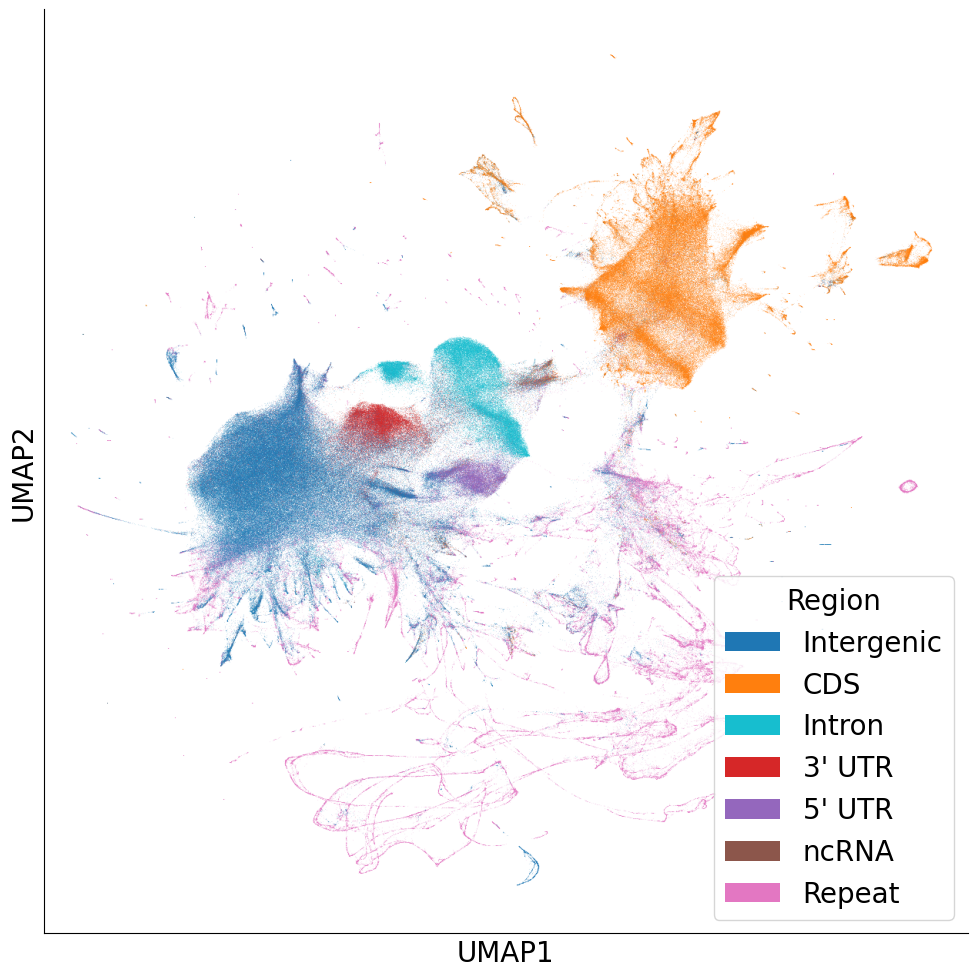

In [9]:
regions = windows.Region.value_counts().index.values

# Make sure Repeat goes last
if "Repeat" in regions:
    regions = regions[regions!="Repeat"].tolist() + ["Repeat"]

    
umap_plot_labels(
    windows.Region, "Region", regions, cmap=color_palette,
    height=1200, width=1200,
    #save_to=f"output/plots/umap_{MODEL.replace('/', '_')}.svg",
)

In [9]:
windows.Region.value_counts()

Region
Intergenic    299778
CDS           197787
Repeat        155170
Intron         79844
3' UTR         46154
5' UTR         30061
ncRNA           9299
Name: count, dtype: int64

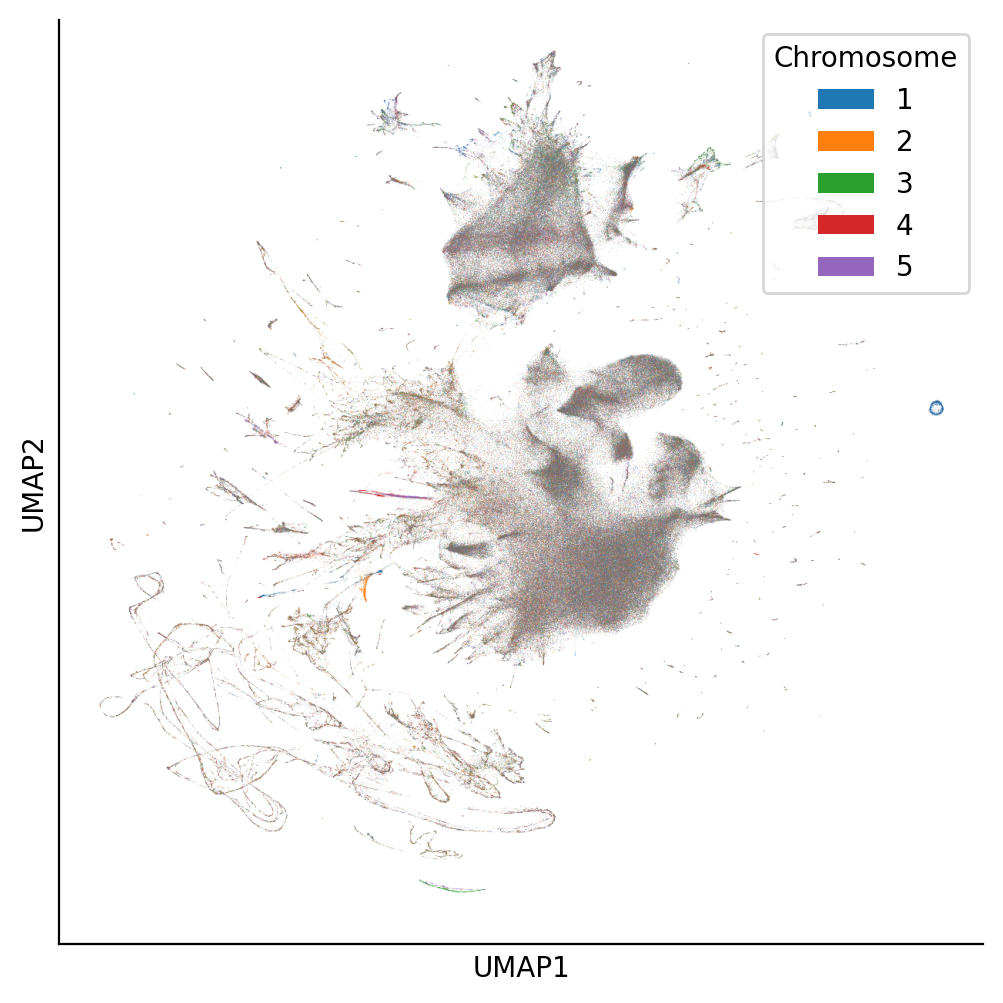

In [48]:
umap_plot_labels(windows.chrom, "Chromosome", windows.chrom.unique(), height=1200, width=1200)

In [49]:
repeats = pd.read_csv("input/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats.chrom = repeats.chrom.str.replace("Chr", "")
repeats

#bin  swScore  milliDiv  milliDel  milliIns chrom     start       end  \
0        10      444       191        54        76     1  12582773  12582920   
1        10     6899        30         0         1     1  13630758  13631561   
2        10     2521        72         3         2     1  14676131  14685672   
3        10     6227        45        48         6     1  15728234  15729041   
4        11      537       291        44       131     1  18873944  18874466   
...     ...      ...       ...       ...       ...   ...       ...       ...   
69340   587      238       156         0         0     M    361356    361401   
69341   587      278       263         0         0     M    361523    361599   
69342   587      582       289        31        44     M    362179    362407   
69343   587      336       258        62        42     M    364854    365016   
69344   587       13       153        25        51     M    365783    365823   

       genoLeft strand        repName        repClass       repFamily  \
0     -17844751      -      Helitron1              RC        Helitron   
1     -16796110      -       ATENSPM2             DNA       CMC-EnSpm   
2     -15741999      -            AR3       Satellite       Satellite   
3     -14698630      +   ATCopia95LTR             LTR           Copia   
4     -11553205      -  Atlantys3_LTR             LTR           Gypsy   
...         ...    ...            ...             ...             ...   
69340     -5523      -   SSU-rRNA_Ath            rRNA            rRNA   
69341     -5325      -   SSU-rRNA_Ath            rRNA            rRNA   
69342     -4517      -   SSU-rRNA_Ath            rRNA            rRNA   
69343     -1908      +   LSU-rRNA_Ath            rRNA            rRNA   
69344     -1101      +        GA-rich  Low_complexity  Low_complexity   

       repStart  repEnd  repLeft  id  
0         -9953    5856     5713   5  
1         -6268    1985     1184   6  
2           -73    9553        1   6  
3             1     841        0   8  
4           -12     482        1   1  
...         ...     ...      ...  ..  
69340       -16    1886     1842   6  
69341      -164    1738     1663   6  
69342      -481    1421     1197   6  
69343       797     961    -2414   6  
69344         1      39        0   6  

[69345 rows x 17 columns]

In [50]:
top_repClass = repeats.repClass.value_counts().head(7).index.values
print(top_repClass)
repeats.repClass.value_counts()

['Simple_repeat' 'Low_complexity' 'DNA' 'LTR' 'RC' 'LINE' 'Satellite']


Simple_repeat     35153
Low_complexity     8892
DNA                8585
LTR                8576
RC                 3882
LINE               1785
Satellite          1347
SINE                616
Other               165
DNA?                112
RC?                  93
LINE?                74
rRNA                 48
SINE?                17
Name: repClass, dtype: int64

In [51]:
repeats.repFamily.value_counts()

Simple_repeat     35153
Low_complexity     8892
Gypsy              5580
MULE-MuDR          3942
Helitron           3882
Copia              2271
L1                 1785
DNA                1281
CMC-EnSpm           853
hAT-Ac              765
centr               752
Cassandra           725
Satellite           595
TcMar-Pogo          468
PIF-Harbinger       420
hAT                 386
TcMar-Stowaway      337
tRNA                334
SINE                282
Composite           161
DNA?                112
hAT-Tag1             99
Helitron?            93
LINE?                74
rRNA                 48
TcMar-Mariner        34
SINE?                17
centromeric           4
Name: repFamily, dtype: int64

In [52]:
repeats.repName.value_counts()

A-rich       5966
(T)n         2878
GA-rich      2864
(A)n         2192
(AT)n        2166
             ... 
(TGCTTG)n       1
(AAAGTG)n       1
(CTCCAA)n       1
(AGCTAG)n       1
(TGACT)n        1
Name: repName, Length: 4194, dtype: int64

In [53]:
# if a window overlaps multiple repeats we just take the first one
windows = bf.overlap(windows, repeats, how="left").drop_duplicates(["chrom", "center_start"])
windows

chrom     start       end strand  center_start  center_end      Region  \
0          1         0       512      +         206.0       306.0  Intergenic   
1          1       100       612      +         306.0       406.0  Intergenic   
2          1       200       712      +         406.0       506.0  Intergenic   
3          1       300       812      +         506.0       606.0  Intergenic   
4          1       400       912      +         606.0       706.0  Intergenic   
...      ...       ...       ...    ...           ...         ...         ...   
897457     5  26974534  26975046      +    26974740.0  26974840.0  Intergenic   
897458     5  26974634  26975146      +    26974840.0  26974940.0  Intergenic   
897459     5  26974734  26975246      +    26974940.0  26975040.0  Intergenic   
897460     5  26974834  26975346      +    26975040.0  26975140.0  Intergenic   
897461     5  26974934  26975446      +    26975140.0  26975240.0  Intergenic   

           UMAP1     UMAP2  #bin_  ...      end_   genoLeft_  strand_  \
0      -0.028450  6.717154  585.0  ...       107 -30427564.0        -   
1      -0.238723  6.999189  585.0  ...       107 -30427564.0        -   
2      -0.622261  6.540700    NaN  ...      <NA>         NaN     None   
3      -0.317216  7.171642    NaN  ...      <NA>         NaN     None   
4      -0.569555  6.597675    NaN  ...      <NA>         NaN     None   
...          ...       ...    ...  ...       ...         ...      ...   
897457  0.268297  6.255438    NaN  ...      <NA>         NaN     None   
897458 -1.554088  2.486017    NaN  ...      <NA>         NaN     None   
897459 -0.515367  2.835551    NaN  ...      <NA>         NaN     None   
897460 -0.267551  3.624983    NaN  ...      <NA>         NaN     None   
897461 -1.955496  2.424752  790.0  ...  26975492       -10.0        +   

        repName_ repClass_  repFamily_  repStart_  repEnd_ repLeft_  id_  
0        ATREP18       DNA         DNA    -1142.0    649.0    561.0  1.0  
1        ATREP18       DNA         DNA    -1142.0    649.0    561.0  1.0  
2           None      None        None        NaN      NaN      NaN  NaN  
3           None      None        None        NaN      NaN      NaN  NaN  
4           None      None        None        NaN      NaN      NaN  NaN  
...          ...       ...         ...        ...      ...      ...  ...  
897457      None      None        None        NaN      NaN      NaN  NaN  
897458      None      None        None        NaN      NaN      NaN  NaN  
897459      None      None        None        NaN      NaN      NaN  NaN  
897460      None      None        None        NaN      NaN      NaN  NaN  
897461   ATREP18       DNA         DNA     1335.0   1445.0   -346.0  6.0  

[818093 rows x 26 columns]

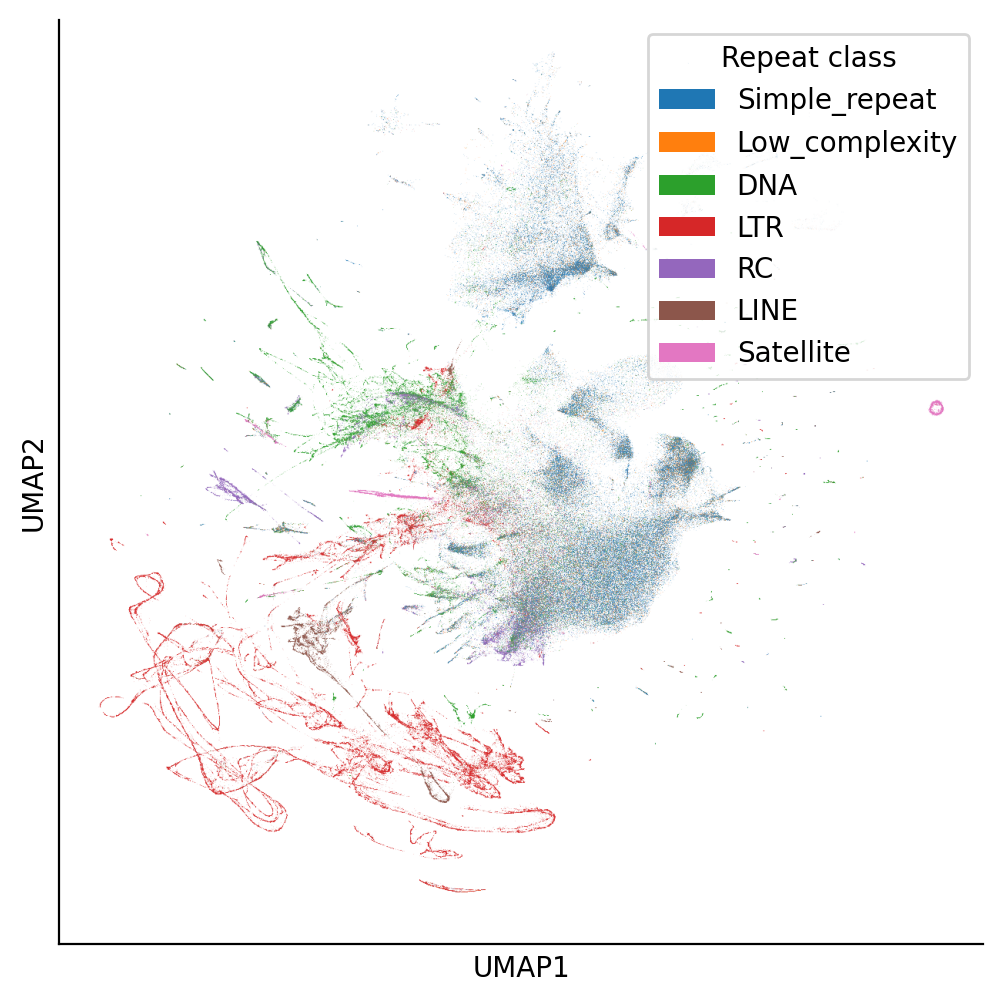

In [54]:
umap_plot_labels(windows.repClass_, "Repeat class", top_repClass, height=1200, width=1200)

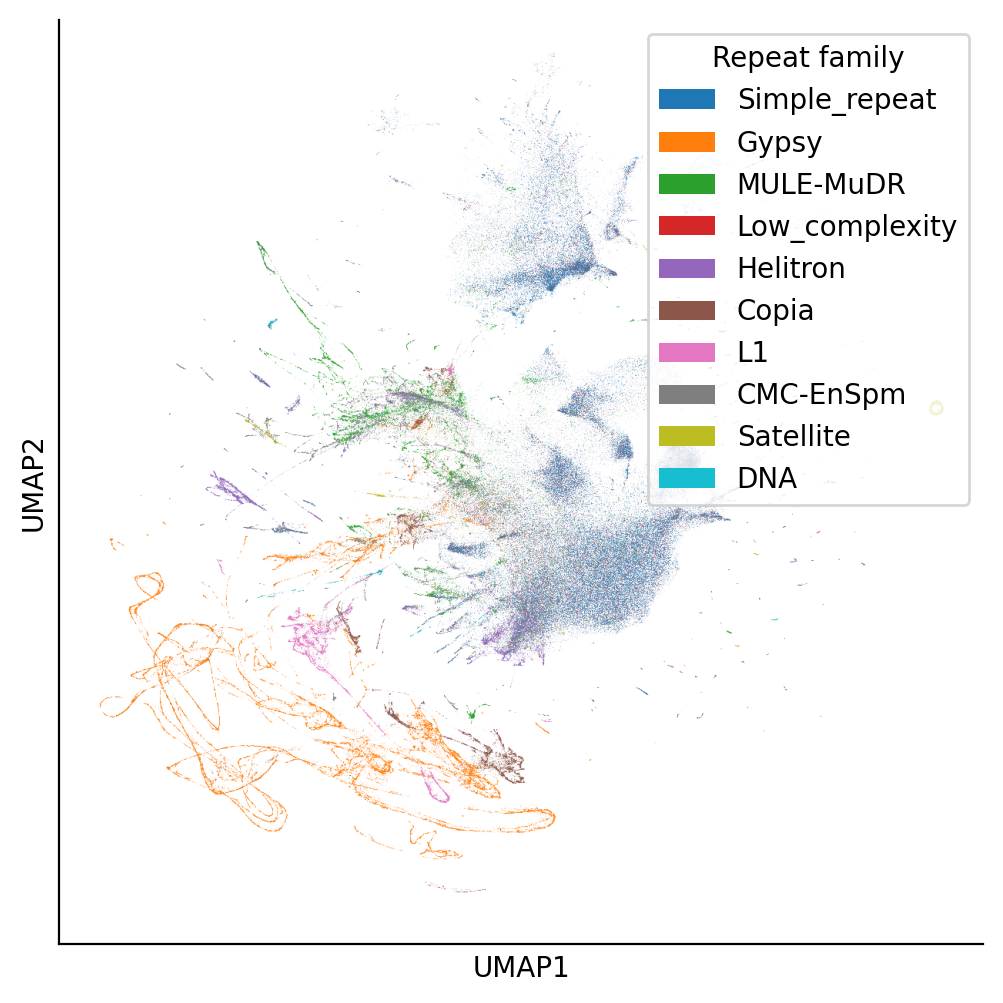

In [55]:
# maybe use a different color palette
umap_plot_labels(windows.repFamily_, "Repeat family", windows.repFamily_.value_counts().head(10).index.values, height=1200, width=1200, save_to="output/plots/umap_repeat_family.pdf")

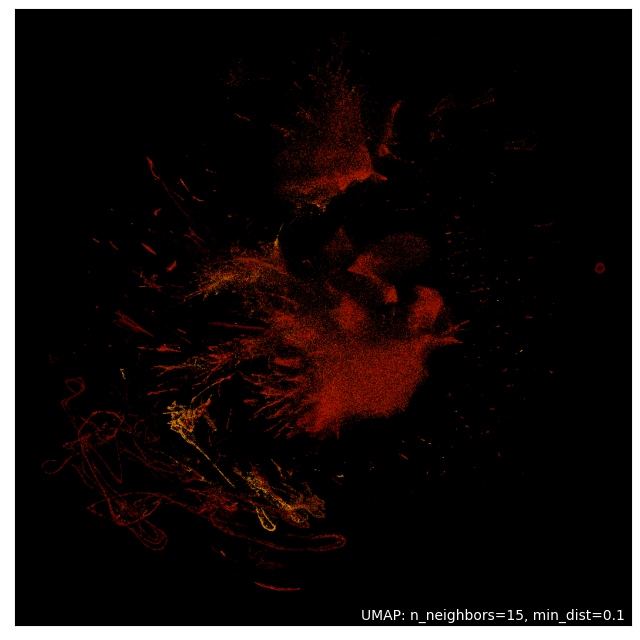

In [16]:
# no idea how to plot colorbar yet
# could just do it in seaborn extracting mapper.embedding
# or with datashader
labels = windows.milliDiv_
g = umap.plot.points(
    mapper,
    values=labels,
    subset_points=~labels.isna(),
    theme="fire",
);

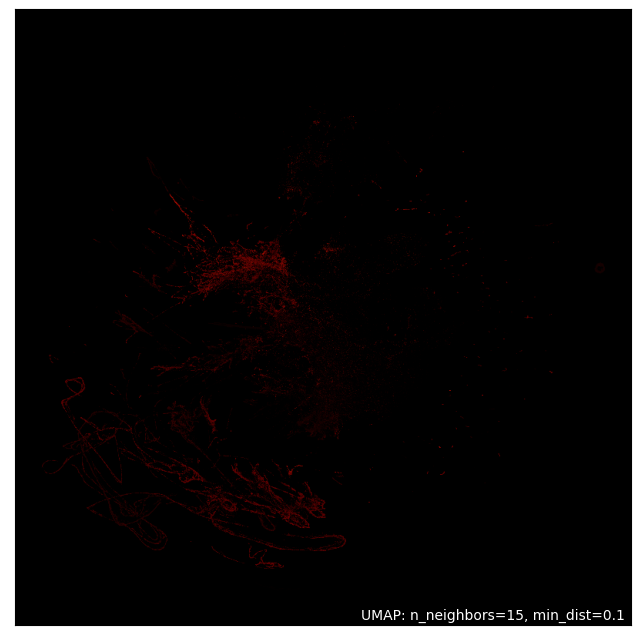

In [17]:
labels = windows.swScore_
g = umap.plot.points(
    mapper,
    values=labels,
    subset_points=~labels.isna(),
    theme="fire",
);

In [18]:
# https://github.com/lmcinnes/umap/issues/485

def umap_plot_values(values, title, cmap="viridis"):
    subset_points = ~values.isna()
    from matplotlib import colors, cm
    fig, ax = plt.subplots(figsize=(8,8))
    # create a scalar colour map for values
    norm = colors.Normalize(values.min(), values.max())
    scalar_map = cm.ScalarMappable(norm=norm, cmap=cmap)  # type: ignore
    # plot using umaps helper function
    umap.plot.points(mapper, values=values, ax=ax, cmap=cmap, subset_points=subset_points)
    # create a colorbar
    cbar = fig.colorbar(scalar_map, ax=ax, label=title, shrink=0.25)  # type: ignore

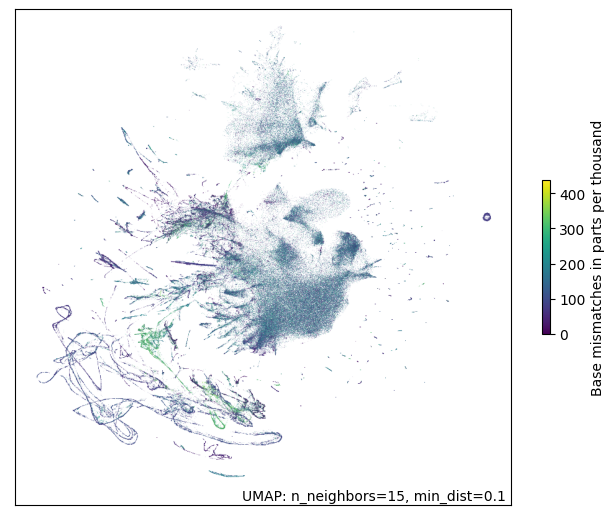

In [19]:
umap_plot_values(windows.milliDiv_, "Base mismatches in parts per thousand")

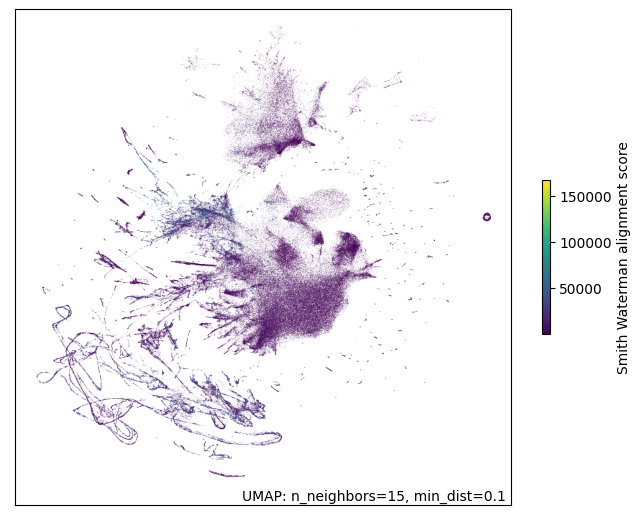

In [20]:
umap_plot_values(windows.swScore_, "Smith Waterman alignment score")